# OOI QC Test Flags - Read & Plot from NetCDF Files

In [2]:
%matplotlib inline
import xarray as xr
import numpy as np
import seaborn as sbs

In [ ]:
# API Information
USERNAME = 'OOIAPI-4J3Y5ISGDUPDB7'
TOKEN = '4OT8YQUME0XOQF'
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
#OOI API to make asynchronous requests 
# Instrument Information
parameters=7989,7987,7
site = 'GP03FLMB'
node = 'RIM01'
instrument = '02-CTDMOG061'
method = 'recovered_inst'
stream = 'ctdmo_ghqr_instrument_recovered'

# Create the request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
    'beginDT': '2016-07-01T00:00:00.000Z',
    'endDT': '2017-07-01T00:00:00.000Z',
    'format':'application/netcdf',
    'parameters': '7989,7987,7',
    'include_provenance':'true',
    'include_annotations':'true'
}
# returns some URLs and some other metadata about our request.
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()
print(data['allURLs'][0])
print( r.status_code )

In [3]:
filename = 'deployment0004_GP03FLMB-RIM01-02-CTDMOG061-recovered_inst-ctdmo_ghqr_instrument_recovered_20160704T231501-20170630T234501.nc'

In [28]:
ds = xr.open_dataset(filename)

In [56]:
ds.attrs

{'node': 'RIM01',
 'comment': '',
 'publisher_email': '',
 'sourceUrl': 'http://oceanobservatories.org/',
 'collection_method': 'recovered_inst',
 'stream': 'ctdmo_ghqr_instrument_recovered',
 'featureType': 'point',
 'creator_email': '',
 'publisher_name': 'Ocean Observatories Initiative',
 'date_modified': '2019-10-29T16:21:27.725765',
 'keywords': '',
 'cdm_data_type': 'Point',
 'references': 'More information can be found at http://oceanobservatories.org/',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'date_created': '2019-10-29T16:21:27.725758',
 'id': 'GP03FLMB-RIM01-02-CTDMOG061-recovered_inst-ctdmo_ghqr_instrument_recovered',
 'requestUUID': 'bde7d3a1-8db9-434b-9911-c6881eb57189',
 'contributor_role': '',
 'summary': 'Dataset Generated by Stream Engine from Ocean Observatories Initiative',
 'keywords_vocabulary': '',
 'institution': 'Ocean Observatories Initiative',
 'naming_authority': 'org.oceanobservatories',
 'feature_Type': 'point',
 'infoUrl': 'http://ocean

In [45]:
ds.variables

Frozen({'obs': <xarray.IndexVariable 'obs' (obs: 34659)>
array([    0,     1,     2, ..., 34656, 34657, 34658], dtype=int32), 'time': <xarray.Variable (obs: 34659)>
array(['2016-07-04T23:15:01.000000000', '2016-07-04T23:30:01.000000000',
       '2016-07-04T23:45:01.000000000', ..., '2017-06-30T23:15:01.000000000',
       '2017-06-30T23:30:01.000000000', '2017-06-30T23:45:01.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T, 'deployment': <xarray.Variable (obs: 34659)>
array([4, 4, 4, ..., 4, 4, 4], dtype=int32)
Attributes:
    name:     deployment, 'id': <xarray.Variable (obs: 34659)>
array([b'55e5f4da-85ab-425d-8319-3406bebbfe05',
       b'9a869526-f5ad-4afe-b991-994da52edbcd',
       b'9b51d4b1-1c3c-435d-8b05-d6fdb7b84f61', ...,
       b'8c9245ac-749f-410f-9a76-53fb6f463375',
       b'8999a491-1f3d-4b14-8267-3e161bef3ed2',
       b'7859fbc8-6add-47ad-b68e-6c4107f3e619'], dtype='|S36')
Attributes:
    name:  

In [57]:
# And let's focus on just one parameter for now, convert to dataframe since this is all scalar data
df = ds[['ctdmo_seawater_pressure', 'ctdmo_seawater_pressure_qc_executed', 'ctdmo_seawater_pressure_qc_results','time']].to_dataframe()
# Re-index by time
df = df.set_index(df['time'])
# drop time columns
df = df.drop('time',axis=1)

In [8]:
df.head()

,ctdmo_seawater_pressure,ctdmo_seawater_pressure_qc_executed,ctdmo_seawater_pressure_qc_results
time,,,
2016-07-04 23:15:01,6.408953,29,29
2016-07-04 23:30:01,19.508035,29,29
2016-07-04 23:45:01,93.363346,29,29
2016-07-05 00:00:01,62.972542,29,29
2016-07-05 00:15:01,52.830192,29,29


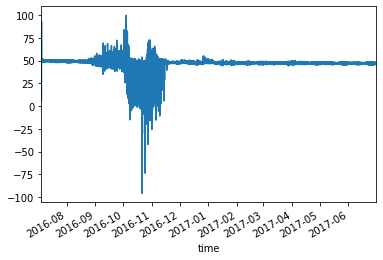

In [9]:
df.ctdmo_seawater_pressure.plot()

QC table
```
Test name              Bit position
                         15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0
global_range_test         0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
dataqc_localrangetest     0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
dataqc_spiketest          0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
dataqc_polytrendtest      0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
dataqc_stuckvaluetest     0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
dataqc_gradienttest       0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
dataqc_propagateflags     0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
```

The QC flags for all tests are ordered together to produce a single value for each data point. 
So, given a qc_executed value of 29 we can see which tests were run by reversing the process:

In [58]:
np.unpackbits(np.array(29).astype('uint8'))

array([0, 0, 0, 1, 1, 1, 0, 1], dtype=uint8)

If you compare this result to the table above you can see that the following tests were executed:

```
global_range_test
dataqc_spiketest
dataqc_polytrendtest
dataqc_stuckvaluetest
```

We can craft a function to create new booleans variables for each test run containing the pass/fail results from that test:

In [11]:
i_executed = 'ctdmo_seawater_pressure_qc_executed'
i_results = 'ctdmo_seawater_pressure_qc_results'

In [12]:
def parse_qc(dataframe, i_executed, i_results):
    names = {
        0: 'global_range_test',
        1: 'dataqc_localrangetest',
        2: 'dataqc_spiketest',
        3: 'dataqc_polytrendtest',
        4: 'dataqc_stuckvaluetest',
        5: 'dataqc_gradienttest',
        7: 'dataqc_propagateflags',
    }
    # Just in case a different set of tests were run on some datapoint
    # *this should never happen*
    executed = np.bitwise_or.reduce(dataframe[i_executed].values)
    executed_bits = np.unpackbits(executed.astype('uint8'))
    for index, value in enumerate(executed_bits[::-1]):
        if value:
            name = names.get(index)
            mask = 2**index
            values = (dataframe[i_results].values & mask) > 0
            dataframe[name] = values
    dataframe.drop([i_executed, i_results], axis=1, inplace=True)

In [13]:
parse_qc(df, i_executed, i_results)

In [14]:
df.head()

,ctdmo_seawater_pressure,global_range_test,dataqc_spiketest,dataqc_polytrendtest,dataqc_stuckvaluetest
time,,,,,
2016-07-04 23:15:01,6.408953,True,True,True,True
2016-07-04 23:30:01,19.508035,True,True,True,True
2016-07-04 23:45:01,93.363346,True,True,True,True
2016-07-05 00:00:01,62.972542,True,True,True,True
2016-07-05 00:15:01,52.830192,True,True,True,True


In [15]:
df[df['dataqc_spiketest'] == False].head()

,ctdmo_seawater_pressure,global_range_test,dataqc_spiketest,dataqc_polytrendtest,dataqc_stuckvaluetest
time,,,,,
2016-11-14 06:15:01,5.686383,True,False,True,True


In [16]:
df[df['global_range_test'] == False].head

<bound method NDFrame.head of                      ctdmo_seawater_pressure  global_range_test  \
time                                                              
2016-10-08 05:00:01               -14.960024              False   
2016-10-08 06:00:01                -2.077202              False   
2016-10-08 06:15:01                -0.576645              False   
2016-10-08 13:45:01                -0.522668              False   
2016-10-08 17:30:01                -4.595976              False   
...                                      ...                ...   
2016-11-09 07:30:01                -2.018951              False   
2016-11-09 12:15:01                -4.679393              False   
2016-11-09 12:30:01                -3.582472              False   
2016-11-09 12:45:01                -6.622191              False   
2016-11-09 13:00:01               -10.688371              False   

                     dataqc_spiketest  dataqc_polytrendtest  \
time                               

/Users/leilabelabassi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


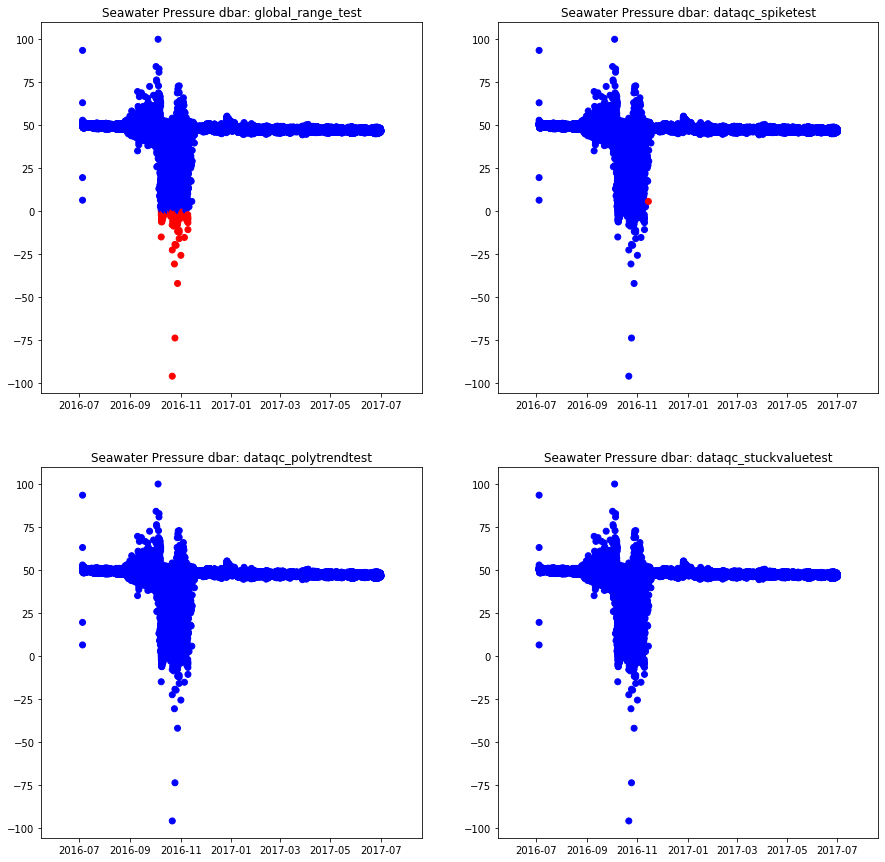

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplot(2, 2, 1)
for x in [1,2,3,4]:
    col_name = df.columns[x]
    colors_i = ['b' if flag==True else 'r' for flag in df[col_name]]
    plt.subplot(2, 2, x)
    plt.scatter(df.index,df['ctdmo_seawater_pressure'], color=colors_i)
    plt.title('Seawater Pressure dbar: '+df.columns[x])

# END